In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [115]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

cols = ['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet',
       'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep',
       'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'DER_lep_eta_centrality',
       'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt',
       'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
       'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta',
       'PRI_jet_subleading_phi', 'PRI_jet_all_pt']


In [98]:
## Preprocessing

def one_hot_jet_num(tX, idx=-1):
 
    #extract the jet_num column
    one_hot = tX[:,idx].astype(int)
    jet_num = np.zeros((tX.shape[0], 4))
    
    #create one column for each possible valur of jet_num
    jet_num[np.where(one_hot == 0),0] = 1
    jet_num[np.where(one_hot == 1),1] = 1
    jet_num[np.where(one_hot == 2),2] = 1
    jet_num[np.where(one_hot == 3),3] = 1

    #create empty array to contain the  new values 
    tX_hot = np.empty((tX.shape[0], 30+3))
    
    #fill the new array without jet_num
    tX_hot[:,:-4] = tX[:,:-1]

    #add the 4 news columns
    tX_hot[:,[-4,-3,-2,-1]] = jet_num
    return tX_hot

""" -- Data cleaning -- """

def nan_to_mean(x):
    '''Set NaN values to the value of the mean for each feature'''
    
    x[x == -999] = np.nan
    col_mean = np.nanmean(x, axis=0)
    inds = np.where(np.isnan(x))
    x[inds] = np.take(col_mean, inds[1])
    
    return x

def nan_to_zero(x):
    '''Set NaN values to the value of the mean for each feature'''
    
    x[x == -999] = np.nan
    x[np.isnan(x)] = 0    
    return x

def nan_to_medi(x):
    '''Set NaN values to the value of the mean for each feature'''
    
    x[x == -999] = np.nan
    col_median = np.nanmedian(x, axis=0)
    inds = np.where(np.isnan(x))
    x[inds] = np.take(col_median, inds[1])
    return x

def cross_validation_ridge(y, x, k_indices, k, lambda_):
    
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    x_train = x[np.concatenate(([x_train for i,x_train in enumerate(k_indices) if i!=k]), axis=0)]
    y_train = y[np.concatenate(([y_train for i,y_train in enumerate(k_indices) if i!=k]), axis=0)]
    
    mse, w = ridge_regression(y_train, x_train, lambda_)
    
    loss_tr = np.sqrt(2*compute_mse(y_train,x_train,w))
    loss_te = np.sqrt(2*compute_mse(y_test ,x_test ,w))
    
    return loss_tr, loss_te, w

def cross_validation_logreg(y, x, k_indices, k, gamma, steps):
    
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    x_train = x[np.concatenate(([x_train for i,x_train in enumerate(k_indices) if i!=k]), axis=0)]
    y_train = y[np.concatenate(([y_train for i,y_train in enumerate(k_indices) if i!=k]), axis=0)]
    
    #starting with random weights
    w = np.random.rand(x_train.shape[1],)
    for step in range(steps):
        loss, w = learning_by_gradient_descent(y_train, x_train, w, gamma)
        
    loss_tr = compute_mse(y_train,x_train,w)
    loss_te = compute_mse(y_test ,x_test ,w)
    
    return loss_tr, loss_te, w

In [116]:
from implementations import *

#move jet_num to the last position
tX.T[[22,-1]] = tX.T[[-1,22]]
tX[tX == -999] = np.nan
print(tX[1,-3:])

tX = cols_log_transform(tX)
print(tX[1,-3:])
deg = 2

tX_ = np.zeros([tX.shape[0], (tX.shape[1]-1)*deg +2])
tX_[:,:-1] = build_poly(tX[:,:-1],2)
tX_[:,-1] = tX[:,-1]

tX_[:,1:-1] = normalize_data_std(tX_[:,1:-1])
print(tX_[1,-3:])
tX_md = np.ndarray.copy(tX_)
tX_me = np.ndarray.copy(tX_)
tX_ze = np.ndarray.copy(tX_)

[nan nan  1.]
[nan nan  1.]
[nan nan  1.]


In [117]:
print(nan_to_medi(tX_md)[1,-3:])
print(nan_to_mean(tX_me)[1,-3:])
print(nan_to_zero(tX_ze)[1,-3:])

[-0.35958576 -0.27819319  1.        ]
[-1.41613605e-14 -2.24237748e-14  1.00000000e+00]
[0. 0. 1.]


In [96]:
np.logspace(-2,0,3)

array([0.01, 0.1 , 1.  ])

In [121]:
seed = 12864126
k_fold = 4
gammas = np.logspace(-15,-6,5)
steps=3000

# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)
# define lists to store the loss of training data and test data
rmse_tr_md = []
rmse_te_md = []
rmse_tr_ma = []
rmse_te_ma = []
rmse_tr_ze = []
rmse_te_ze = []

ws_md = []
ws_ma = []
ws_ze = []

#for lambda_ in lambdas:
for gamma in gammas:
    rmse_tr_tmp_md = []
    rmse_te_tmp_md = []
    rmse_tr_tmp_ma = []
    rmse_te_tmp_ma = []
    rmse_tr_tmp_ze = []
    rmse_te_tmp_ze = []
    for k in range(k_fold):
        loss_tr_md, loss_te_md, w_md = cross_validation_logreg(y, tX_md, k_indices, k, gamma, steps)
        loss_tr_ma, loss_te_ma, w_ma = cross_validation_logreg(y, tX_me, k_indices, k, gamma, steps)
        loss_tr_ze, loss_te_ze, w_ze = cross_validation_logreg(y, tX_ze, k_indices, k, gamma, steps)

        rmse_tr_tmp_md.append(loss_tr_md)
        rmse_te_tmp_md.append(loss_te_md)
        rmse_tr_tmp_ma.append(loss_tr_ma)
        rmse_te_tmp_ma.append(loss_te_ma)
        rmse_tr_tmp_ze.append(loss_tr_ze)
        rmse_te_tmp_ze.append(loss_te_ze)
    ws_md.append(w_md)
    ws_ma.append(w_ma)
    ws_ze.append(w_ze)
    #combine the loss over the folds
    rmse_tr_md.append(np.mean(rmse_tr_tmp_md))
    rmse_te_md.append(np.mean(rmse_te_tmp_md))
    rmse_tr_ma.append(np.mean(rmse_tr_tmp_ma))
    rmse_te_ma.append(np.mean(rmse_te_tmp_ma))
    rmse_tr_ze.append(np.mean(rmse_tr_tmp_ze))
    rmse_te_ze.append(np.mean(rmse_te_tmp_ze))

/home/toinou/Documents/master/ma1/ml/ml_proj1/scripts/implementations.py:218: RuntimeWarning: overflow encountered in exp
  s = 1.0/(1.0 + np.exp(-t))


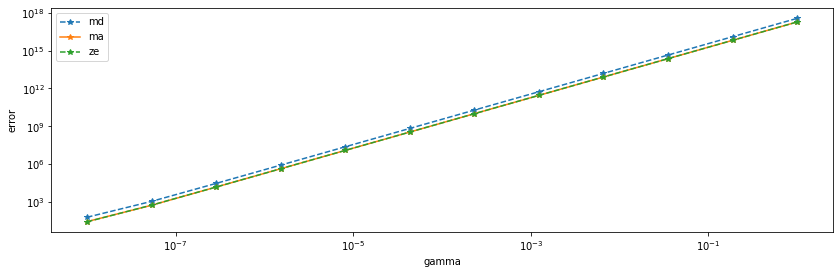

In [120]:
f = plt.figure(figsize=(14,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
ax1.semilogx(gammas, rmse_te_md, ls="--" , marker="*", label="md")
ax1.semilogx(gammas, rmse_te_ma, ls="-" , marker="*", label="ma")
ax1.semilogx(gammas, rmse_te_ze, ls="--" , marker="*", label="ze")

plt.xlabel("gamma")
plt.ylabel("error")
plt.yscale("log")
plt.legend()
plt.show()

In [6]:
w0 = np.random.rand(tX_2.shape[1])

In [106]:
seed = 672581
k_fold = 4
lambdas = np.logspace(-8,-1,8)

#putting jet_num in the last column
tX.T[[22,-1]] = tX.T[[-1,22]]
tX[tX == -999] = np.nan

#split data based on jet_num
"""WARNING tX must be unprocessed data so that the processing can
be jet_num specific WARNING""" 
#remove the jet_num column -> change the shape of the training set
pred_0, pred_1, pred_2, dat_0, dat_1, dat_2, inds_0, inds_1, inds_2 = split_jet_num(y,tX)

##prepocessing
dat_0 = cols_log_transform(dat_0)
dat_1 = cols_log_transform(dat_1)
dat_2 = cols_log_transform(dat_2)

deg = 7

"""we don't have the same shape because of jet_num removal
instead of (shape-1)*deg + 2 -> shape*deg +1"""
dat_0_ = np.zeros([dat_0.shape[0], (dat_0.shape[1])*deg +1])
dat_1_ = np.zeros([dat_1.shape[0], (dat_1.shape[1])*deg +1])
dat_2_ = np.zeros([dat_2.shape[0], (dat_2.shape[1])*deg +1])

dat_0_ = build_poly(dat_0,deg)
dat_1_ = build_poly(dat_1,deg)
dat_2_ = build_poly(dat_2,deg)

#we don't standardize the first column because its the constant
#introduced by the build_poly
dat_0_[:,1:] = normalize_data_std(dat_0_[:,1:])
dat_1_[:,1:] = normalize_data_std(dat_1_[:,1:])
dat_2_[:,1:] = normalize_data_std(dat_2_[:,1:])

nan_to_mean(dat_0_)
nan_to_mean(dat_1_)
nan_to_mean(dat_2_)

# split data in k fold
k_indices_0 = build_k_indices(pred_0, k_fold, seed)
k_indices_1 = build_k_indices(pred_1, k_fold, seed)
k_indices_2 = build_k_indices(pred_2, k_fold, seed)

rmse_tr_0 = []
rmse_te_0 = []
rmse_tr_1 = []
rmse_te_1 = []
rmse_tr_2 = []
rmse_te_2 = []

ws_0 =[]
ws_1 =[]
ws_2 =[]

#for lambda_ in lambdas:
for lambda_ in lambdas:
    rmse_tr_tmp_0 = []
    rmse_te_tmp_0 = []
    rmse_tr_tmp_1 = []
    rmse_te_tmp_1 = []
    rmse_tr_tmp_2 = []
    rmse_te_tmp_2 = []
    for k in range(k_fold):
        loss_tr_0, loss_te_0, w_0 = cross_validation_ridge(pred_0, dat_0_, k_indices_0, k, lambda_)
        loss_tr_1, loss_te_1, w_1 = cross_validation_ridge(pred_1, dat_1_, k_indices_1, k, lambda_)
        loss_tr_2, loss_te_2, w_2 = cross_validation_ridge(pred_2, dat_2_, k_indices_2, k, lambda_)

        rmse_tr_tmp_0.append(loss_tr_0)
        rmse_te_tmp_0.append(loss_te_0)
        rmse_tr_tmp_1.append(loss_tr_1)
        rmse_te_tmp_1.append(loss_te_1)
        rmse_tr_tmp_2.append(loss_tr_2)
        rmse_te_tmp_2.append(loss_te_2)
    ws_0.append(w_0)
    ws_1.append(w_1)
    ws_2.append(w_2)
    
    #combine the loss over the folds
    rmse_tr_0.append(np.mean(rmse_tr_tmp_0))
    rmse_te_0.append(np.mean(rmse_te_tmp_0))
    rmse_tr_1.append(np.mean(rmse_tr_tmp_1))
    rmse_te_1.append(np.mean(rmse_te_tmp_1))
    rmse_tr_2.append(np.mean(rmse_tr_tmp_2))
    rmse_te_2.append(np.mean(rmse_te_tmp_2))

array([1.00000000e-08, 5.33669923e-08, 2.84803587e-07, 1.51991108e-06,
       8.11130831e-06, 4.32876128e-05, 2.31012970e-04, 1.23284674e-03,
       6.57933225e-03, 3.51119173e-02, 1.87381742e-01, 1.00000000e+00])

[[1.5376   6.125625 4.      ]
 [0.       0.       1.      ]
 [0.       0.       1.      ]
 ...
 [0.       0.       1.      ]
 [0.       0.       0.      ]
 [0.       0.       0.      ]]


In [18]:
from implementations import *
seed = 746183561
gamma = 0.01
steps = 8000
ratio = .8

#preprocessing specific to log regression
y[np.where(y == -1)] = 0

#tX_hot_2 = build_poly(tX_hot,2)

#losses_ = []
#losses_m = []
losses_z = []

#using last run weights
#w = weights
#random starting weights
#w = np.random.rand(tX_2.shape[1])
w_tx = w0
w_me = w0
w_ze = w0

#ws_ = []
#ws_m = []
ws_z = []

for step in range(steps):
    #loss, w_tx = learning_by_gradient_descent(y, tX_2, w_tx, gamma)
    #losses_.append(loss)
    #loss, w_me = learning_by_gradient_descent(y, tX_mean_2, w_me, gamma)
    #losses_m.append(loss)
    loss, w_ze = learning_by_gradient_descent(y, tX_zero_2, w_ze, gamma)
    losses_z.append(loss)

    ws_.append(w_tx)
    ws_m.append(w_me)
    ws_z.append(w_ze)

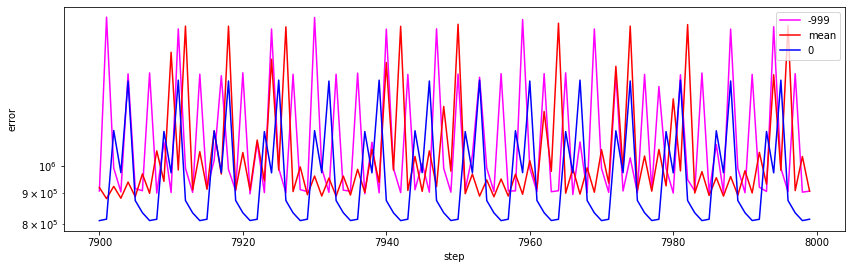

In [19]:
f = plt.figure(figsize=(14,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
ax1.plot(range(steps)[-100:], losses_[-100:], 'magenta', label="-999")
ax1.plot(range(steps)[-100:], losses_m[-100:], 'red', label="mean")
ax1.plot(range(steps)[-100:], losses_z[-100:], 'blue', label="0")

#ax1.plot(range(steps), losses_te, 'brown', label="rmse_te_deg1")

plt.xlabel("step")
plt.ylabel("error")
plt.yscale("log")

plt.legend()
plt.show()

In [24]:
mse_  = [compute_mse(y, tX, w) for w in ws_]
mse_m = [compute_mse(y, tX_mean, w) for w in ws_m]
mse_z = [compute_mse(y, tX_zero, w) for w in ws_z]

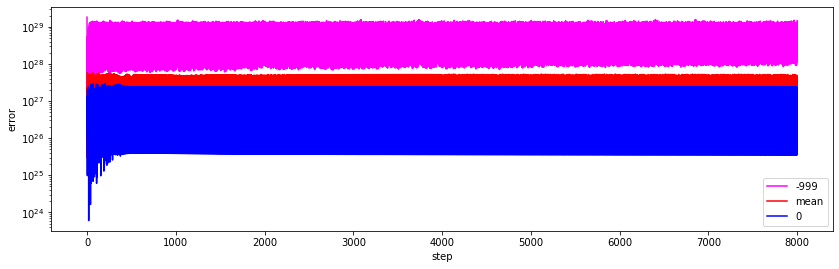

In [38]:
f = plt.figure(figsize=(14,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
ax1.plot(range(steps), mse_[:8000], 'magenta', label="-999")
ax1.plot(range(steps), mse_m[:8000], 'red', label="mean")
ax1.plot(range(steps), mse_z[:8000], 'blue', label="0")

#ax1.plot(range(steps), losses_te, 'brown', label="rmse_te_deg1")

plt.xlabel("step")
plt.ylabel("error")
plt.yscale("log")

plt.legend()
plt.show()

In [43]:
print(min(mse_))
print(min(mse_m))
print(min(mse_z))

54059609325.65468
54059609325.65468
6.024303373125174e+23


In [44]:
print(mse_.index(54059609325.65468))
print(mse_m.index(54059609325.65468))
print(mse_z.index(6.024303373125174e+23))

8000
8000
19


## Least_squares_DG

## Least_squares_SDG
Ne donne que des loss = nan, le calcul du gradient ne se passe pas bien, que ça soit avec les rows contenant du -999 ou pas.

## Least_square
degree 1 -> -334.4 (mse loss)

## Ridge_regression
Seems the most suited since we have so many features. Maybe we could remove some features if they are highly correlated (might be visible on plots?
degree = 6 -> singular matrix

## Logistic_regression
Since we have a binary output, it might be the best option...

## Reg_logistic_regression

# Remarks
if degree = 3, 7, ...
-> LinAlgError: Singular matrix



# TODO
- plot all the variable with boxplot
- compute ,np.cov between the variables
- compute Pearson correlation np.cov(x,y)/(std(x) * std(y))

In [109]:
weights = np.array([-2.12420734e-01,  1.16707954e+00, -2.02597113e-01, -3.41018773e-01,
        2.56824923e-02, -4.54348442e-01, -3.21897544e-01, -2.31903708e-01,
        4.32510496e-01, -1.48819486e-02, -9.01831769e-02,  7.66891467e-03,
       -1.42167862e-01, -9.69461879e-02,  2.44652837e-01,  9.49255189e-03,
        4.08476796e-03,  3.83936896e-01,  6.98400776e-03,  5.64949226e-03,
        1.86038783e-01, -6.43892259e-03,  2.96360086e-01, -5.65704332e-01,
       -4.34824317e-02, -4.41479764e-03, -1.90244121e-02,  2.21996400e-02,
        8.67438189e-04, -2.01798116e-03, -2.44247984e+00, -3.28859729e-01,
       -3.35424574e-02, -1.15704860e-01,  5.02151127e-01,  7.87037444e-01,
       -9.12315688e-02,  7.18300905e-02,  2.37105547e-01,  1.91215608e-03,
        2.42159443e-01, -2.36433007e-02,  3.15667185e-01,  3.61504589e-01,
       -1.12255968e-02, -8.40961826e-03, -3.50403103e-02, -5.55229351e-02,
        1.90028958e-02, -4.76703114e-01, -1.15650893e-03, -7.04232927e-01,
        4.81431733e-01, -1.22265200e-01,  1.95102924e-01,  7.75301832e-03,
        6.40327368e-02,  2.66963521e-01, -1.86260588e-02,  1.40283436e+00,
        1.17789093e+00,  5.99433456e-01, -7.57438996e-02,  1.71001227e-01,
       -6.36827920e-01,  1.16597701e-01, -3.95447289e-01, -2.27512737e-01,
       -9.82274612e-03, -3.39027437e-01,  2.10071550e-01,  6.47930487e-02,
        1.71891855e-01, -7.15097555e-02, -1.16710685e-02, -2.15331366e-01,
       -2.34377038e-02, -2.41963601e-02, -9.29453147e-02,  2.95083446e-03,
        3.90347381e-01,  5.64074893e-01,  1.56512022e-01,  3.06499918e-04,
        2.55378129e-02, -7.29927579e-02, -1.72607210e-02, -2.41581709e-02,
        1.16767296e+00, -1.25954122e+00, -6.48927489e-01,  9.35883737e-02,
       -2.59989711e-01, -1.18058514e-01,  9.93680655e-02, -2.06209383e-01,
       -2.31787284e-01, -5.59965477e-02,  1.05208282e-01,  1.05079399e-01,
       -9.85260151e-02, -1.34187339e-01, -5.17812745e-02,  9.24620619e-03,
       -2.09590499e-01, -1.67864559e-02, -4.18423703e-02,  2.84541469e-01,
        1.41375357e-02,  2.51100500e-01,  2.08493577e-01,  2.32707626e-02,
       -2.61713147e-02, -4.97859235e-03, -8.73171313e-03, -1.25373183e-01,
        2.83786478e-02, -1.04553243e+00, -5.97598023e-02, -1.69821364e-01,
        1.56129030e-01, -2.94497472e-01,  3.27816931e-01, -9.32331679e-02,
        2.34311590e-01,  8.21825489e-02, -7.14323265e-02,  1.52650663e-01,
        2.44560032e-01, -1.21730364e-01, -3.44081014e-01,  1.39648103e-01,
        8.57709474e-03, -8.95776897e-02,  2.71186939e-02,  5.10524877e-02,
        3.18027058e-01,  1.72901021e-02, -2.66100442e-01, -1.63552734e-01,
       -1.05308385e-01,  5.56972346e-03, -1.04720088e-02,  4.06576146e-02,
        2.66032297e-02,  3.87502090e-02, -9.63486856e-01,  8.10929532e-01,
        2.94900236e-01,  7.13048473e-02, -5.43757066e-02,  1.71740488e-01,
       -5.32192166e-02,  3.61585389e-01,  2.48992499e-01, -1.49290596e-03,
       -3.61615922e-02, -7.16868553e-02, -4.19519991e-02, -2.56553946e-01,
        2.93938375e-02, -2.35241795e-04,  5.87049746e-02,  1.74348031e-02,
        2.41020704e-02,  5.80991627e-02, -1.41801825e-02, -1.94979323e-01,
       -3.01023639e-01, -5.20843848e-02, -2.43597179e-02,  1.42794049e-04,
        2.57971914e-02,  2.86411352e-02, -1.03630775e-02,  8.24358264e-01,
       -3.26634363e-01,  4.98202260e-02, -9.63961102e-02,  2.49664258e-01,
       -2.44598036e-01,  4.01511982e-02, -2.33097951e-01, -9.14237559e-02,
        1.93002042e-01, -5.45464040e-02, -2.54247756e-01,  1.01961752e-01,
        2.78395110e-01, -7.85805290e-02, -1.00442303e-03,  1.43433876e-01,
       -1.13488057e-02, -3.32359540e-02, -2.80988737e-01, -1.51873043e-02,
        1.96578767e-01, -9.47127376e-02,  9.05420349e-02, -1.10923624e-03,
        1.77468762e-03, -2.11963777e-02, -1.01824692e-02, -1.41531617e-02,
       -1.04534368e-01])

## Generate predictions and save ouput in csv format for submission:

In [112]:
DATA_TEST_PATH = '/home/toinou/course/ml/ml_proj1/data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [113]:
#move jet_num to the last position
tX_test.T[[22,-1]] = tX_test.T[[-1,22]]

tX_test[tX_test == -999] = np.nan
print(tX_test[1,-3:])

tX_test = cols_log_transform(tX_test)
print(tX_test[1,-3:])
deg = 7

tX_test_ = np.zeros([tX_test.shape[0], (tX_test.shape[1]-1)*deg +2])
tX_test_[:,:-1] = build_poly(tX_test[:,:-1],deg)
tX_test_[:,-1] = tX_test[:,-1]

tX_test_[:,1:-1] = normalize_data_std(tX_test_[:,1:-1])
print(tX_test_[1,-3:])


nan_to_mean(tX_test_)

print(tX_test_[1,-3:])

[nan nan  1.]
[nan nan  1.]
[nan nan  1.]
[ 7.41207847e-18 -2.71083336e-17  1.00000000e+00]


In [114]:
OUTPUT_PATH = '/home/toinou/course/ml/ml_proj1/sub12.csv'
y_pred = predict_labels(weights, tX_test_)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

## Submissions

1. ridge, degree 2, lambdas = 0.75 -> 0.752
2. ridge, degree 1, lambdas = 0.75 -> 0.732
3. logreg, degree 1, lambda = 0.75 -> 0.662

implementation of normalization and hot one

4. ridge, degree 1, lambdas 0.69 -> 0.752
5. ridge, degree 2, lambdas 0.69 -> 0.732
6. logreg, degree 1, gamma ?     -> (random start, 3000 steps)
7. logreg, degree 1, gamma 1.5   -> 0.696 (random start, one hot, 8000 steps)
8. logreg, degree 1, gamma 1     -> 0.695 (random start, one hot, 8000 steps)
9. logreg, degree 2, gamma 1.5   -> 0.765 (random start, one hot, 8000 steps)
10. logreg, degree 3, gamma 1.5   -> 0.660 (random start, one hot, 12000 steps)

In [ ]:
np.array([0,2,1,2,3,4,1,2])+10**-5